# Common Cancers Deaths in Men (1990 - 2016)

Table of Contents  

- [Summary](#summary)  
- [Data Wrangling](#wrangling)
- [Exploratory Data Analysis](#eda)
- [Conclusions](#conclusions)


## <a name="summary"></a>Summary

There are 5 common types of cancer in Men, lung cancer, stomach cancer, liver cancer, prostate cancer and colon&rectum cancer. In 2016, more than **1 million** Men die of one of this cancer over the world. 
Which country is affected the most by these cancers? What is the cancer which kill the most? How is the evolution of these cancer deaths since 1990?  
In this project we will analyse the data taken from the [Gapminder World](www.gapminder.org) about these 5 types
of cancer in Men and try to find an answer to these questions.



In [182]:
# Imports all the needed packages for the project
import pandas as pd                # Imports the package for the dataframes
import numpy as np                 # Imports the package for the arrays
import matplotlib.style as style   # Imports the package for the plot
import folium                      # Imports the package For the world map
style.use("fivethirtyeight")       # We use this style for the plots
import matplotlib.pyplot as plt
from functools import reduce
import glob
%matplotlib inline                 

## <a name="wrangling"></a>Data Wrangling  
First of all we import all the separated files and gather it in one unique dataset.  

### General Properties

In [ ]:
## Load all the files 
pattern = "files/*male_deaths.csv"      # Pattern to find all the files that finish with deaths 
all_files = glob.glob(pattern) # Uses the pattern to import all the files and then put it in all_files list
files_names = ["col_rec_df", "stomach_df", "liver_df", "prostate_df", "lung_df"] # List of the name of each file
all_dict = {}                        # Creates an empty dictionary to store the names and dataframes
assert len(all_files) == len(files_names) # Controls if the number of files imported are the same number of names
for i in range(len(all_files)):
    all_dict[files_names[i]] = pd.read_csv(all_files[i]) # Loads each file gives it the right name and put in the dict 


Now that all the files are loaded with a unique name, let us take a look at the structure of each file.

In [ ]:
# Cheks all the dataframe shape 
for name,df in all_dict.items(): 
    print(name, df.shape)       

All five dataframes have same shape **187** observations and **28** variables

In [ ]:
for name,df in all_dict.items():
    print(name, df.head(1)) 

All files are structured in the same way, a country column and years from 1990 to 2016, This structure is no optimal for making an analysis, let us turn it from wide to long for a better analysis.

In [ ]:
# Transform the files from wide to long
def gather(df,value_name:str) -> "df": # Define the function gather that will return a dataframe
    """function to transform and rename the columns """
   
    df = df.melt(id_vars = ["country"],var_name = "year", value_name = value_name + "deaths") # This reshape the data from wide to long, renaming the columns 
    return df     # A data dataframe is returned

# Use the function gather to create "long" dataframes
list_df = []                                         # Create an empty list to contain the new "long" dataframes

for name,df in all_dict.items():                     # Use a loop to access all the files in the dictionnary
    name = gather(df,name[:-2])                      # Use the gather function, name[:-2] -> removes df from each names
    list_df.append(name)                             # Put all the new dataframe in the list 
    
df = reduce(lambda left,right: pd.merge(left,right, on = ["country", "year"]), list_df) # Use the reduce function to merge all the df in a row

df.to_csv("files/common_men_cancers_deaths.csv")   # Write into a csv for future uses
df.head()

In [ ]:
df.info()

After putting all the files toghether, we have a file with 5049 rows and 7 columns. There are no missing values as
all the variables have the same numbers of rows, but the year variable is a string which is not correct. For the next text we will clean the data.  

### Cleaning Data 

We start cleaning the data turning the string year variable into a numeric variable, precisely an integer.

In [ ]:
df.year = pd.to_numeric(df.year)          # Turn the year variable from string type to int64
assert df.year.dtypes == np.dtype("int64")# Check if the type is correct, if no error we are ok

As there is no error thrown, we are sure that the year variable type is correctly changed from string to integer.

In [ ]:
assert df.notnull().all().all()          # We confirm that there are no missing values
assert (df.iloc[:, 1:] > 0).all().all()  # we confirm that all values are greater than zero

At this point we are sure that the data has no missing values, no zero values and all the variables are in
the correct type.

### <a name="eda"></a>Exploratory Data analysis

In [122]:
df.describe()

,year,col_rec_deaths,stomach_deaths,liver_deaths,prostate_deaths,lung_deaths
count,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000
mean,2003.000000,1803.511121,2724.360368,2413.228984,1470.019778,5105.906282
std,7.789652,6553.343062,17347.627108,19456.176523,3670.981779,24621.169653
min,1990.000000,0.780000,1.150000,0.610000,0.820000,2.260000
25%,1996.000000,52.300000,56.600000,46.100000,69.500000,94.900000
50%,2003.000000,217.000000,331.000000,205.000000,308.000000,434.000000
75%,2010.000000,955.000000,999.000000,687.000000,1170.000000,2140.000000
max,2016.000000,104000.000000,257000.000000,324000.000000,35500.000000,424000.000000


The lung cancer seems to be the one wich causes more deaths with a maximum of **424000** deaths a certain year,
the prostate cancer has the lower value with a maximum of **35500** deaths a certain year.

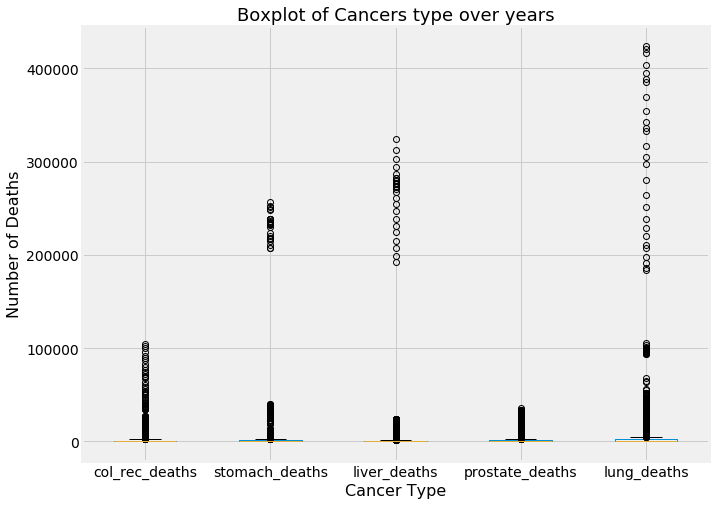

In [183]:
# boxplot to see some statistics
col = df.loc[:, "col_rec_deaths":"lung_deaths"].columns
box_df = df.plot(kind = "box", y = col, figsize = [10,8], fontsize = 14)
box_df.set_title("Boxplot of Cancers type over years",fontsize = 18)
box_df.set_ylabel("Number of Deaths", fontsize = 16)
box_df.set_xlabel("Cancer Type", fontsize = 16);

There are many outliers for each type of cancer, this is probably due to difference between the population of each country, in fact a country with 10 millions Men will probably have more cancer deaths that a country with 50000 Men, that means we cannot consider the mean as an average of deaths. Let us take for example the liver cancer, it has a mean of 2413.2 deaths on average per year but in that situation it will be better to consider the median of 205 deaths on average per year.

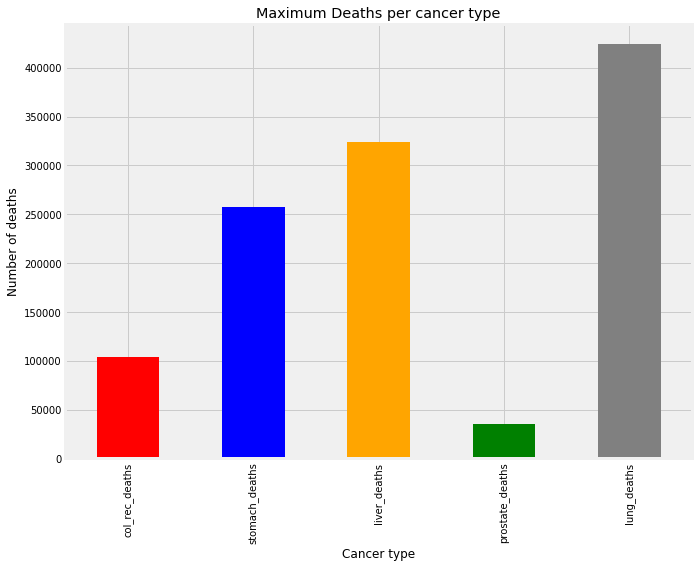

In [173]:
# Plot of the maximum deaths
## Select all the maximums and plot it 
df_max_plt = df.iloc[:,2:].max().plot(kind="bar",color = ["red", "blue", "orange", "green", "grey"],
                                     figsize = [10,8]) 
plt.title("Maximum Deaths per cancer type") # Add a title
plt.ylabel("Number of deaths")              # Add a y label
plt.xlabel("Cancer type");                  # Add a x label

In [165]:
# Find the country with the maximum death value
df_max_country = df[df.values == df.iloc[:,2:].values.max()]
df_max_country

,country,year,col_rec_deaths,stomach_deaths,liver_deaths,prostate_deaths,lung_deaths
4897,China,2016,104000.0,239000.0,324000.0,34100.0,424000.0


In 2016, **424000** Men die of lung cancer just in China which is almost **12** times the number of prostate cancer deaths and almost all the population of Minneapolis city (USA).

In [ ]:
# Find the country with the minimum death value
df_min_country = df[df.values == df.iloc[:,2:].values.min()]
df_min_country

In 1990, Seychelles has the lower number of liver cancer death, in general there are few deaths for each type of 
cancer, but strangely there are more deaths due to prostate cancer.  
For these two statistics(*China* and *Seychelles*) we have to take in consideration the population of each country,
China has a higher population than other countries so the proportion of deaths are probably the same (**That will
be the subject of another study**).

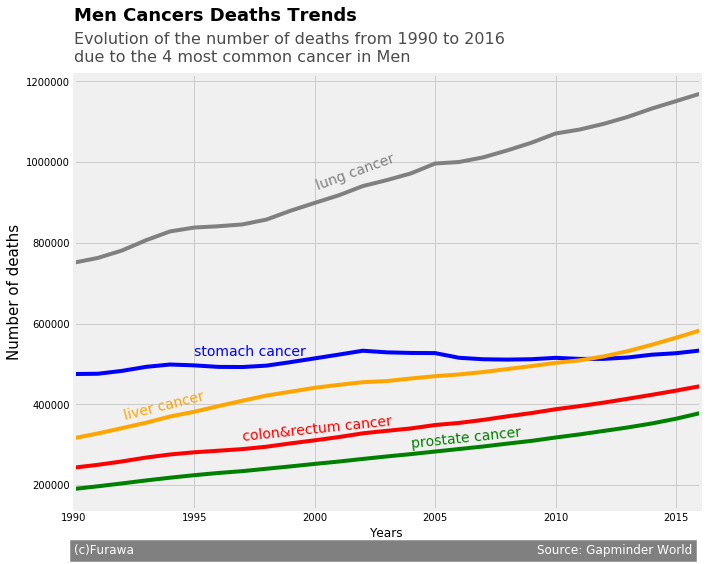

In [177]:
cancers_trends = df.groupby("year").sum().plot(legend = False, color = ["red", "blue", "orange", "green", "grey"],
                                               figsize = (10,8))
# Add a title 
cancers_trends.text(x = 1990, y = 1350000, s = "Men Cancers Deaths Trends", fontsize = 18, weight = "bold")
# Add a subtitle
cancers_trends.text(x = 1990, y = 1250000, s = "Evolution of the number of deaths from 1990 to 2016\ndue to the 4 most common cancer in Men",
                    fontsize = 16, alpha = 0.7)
# Add y label
cancers_trends.set_ylabel("Number of deaths", fontsize = 15)

# Add x label
cancers_trends.set_xlabel("Years")

# Add the label of each legend on the line
cancers_trends.text(x=2000, y = 1000000, s = "lung cancer", fontsize = 14, rotation = 20, color = "grey")
cancers_trends.text(x=1995, y = 520000, s = "stomach cancer",fontsize = 14, color = "blue")
cancers_trends.text(x=1992, y = 410000, s = "liver cancer", fontsize = 14, rotation = 14, color = "orange")
cancers_trends.text(x=2004, y = 320000, s = "prostate cancer", fontsize = 14, rotation = 6, color = "green")
cancers_trends.text(x=1997, y = 350000, s = "colon&rectum cancer", fontsize = 14, rotation = 6, color = "red")
# Add a signature bar
cancers_trends.text(x = 1990, y = 30000, s = "(c)Furawa                                                                                                        Source: Gapminder World",
                   fontsize = 12, backgroundcolor = "grey", color = "white");

The lung Cancer is kills more Men over years. In 2016 more than 1 million Men die of lung cancer 
over the world. Except the stomach cancer deaths (which is quite stable) all the other types of cancer deaths
increase each year. Let us make a world map to have an overview of the situation in 2016.  

In [74]:
# load the world file with the gps of countries
world = pd.read_csv("files/worldcities.csv")
# See the structure of the file
world.head(2)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1901597212
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1901360309


The file do not have population values nor real capital names we will use the longitude and latitude of one city
at random in each country.

In [114]:
# Select just the longiture, latitude, country and cities
world_df = world.iloc[:,2:5]
# Remove duplicates country and keep just the longitude and latitude of one city at random 
world_df.drop_duplicates(subset = "country", keep = "last", inplace = True)
# Sort alphabetically
world_df.sort_values(by = "country", inplace = True)
world_df.head(2)

,lat,lng,country
3973,34.5167,65.2500,Afghanistan
4001,41.3275,19.8189,Albania


Here is our final world table with country longiture and latitude, that we will use for the map.

In [115]:
# Calulate the sum of all deaths in 2016
cancers_2016 = df[df.year == 2016].drop(columns = ("year"), axis = 1)  # Select 2016, drop year to don't have it in the sum
cancers_2016.loc[: , "total_deaths"] = cancers_2016.sum(axis = 1) # Create the total_deaths column
cancers_2016.head(2)

,country,col_rec_deaths,stomach_deaths,liver_deaths,prostate_deaths,lung_deaths,total_deaths
4862,Afghanistan,599.0,1450.0,440.0,456.0,1930.0,4875.0
4863,Albania,149.0,323.0,251.0,337.0,818.0,1878.0


In [117]:
# Merge the world_df and cancers_2016 toghether
world_cancers_df = world_df.merge(cancers_2016, how = "inner", on = "country")
world_cancers_df.head(2)

,lat,lng,country,col_rec_deaths,stomach_deaths,liver_deaths,prostate_deaths,lung_deaths,total_deaths
0,34.5167,65.2500,Afghanistan,599.0,1450.0,440.0,456.0,1930.0,4875.0
1,41.3275,19.8189,Albania,149.0,323.0,251.0,337.0,818.0,1878.0


In [119]:
cancer_map = folium.Map(location = [20,0], tiles = "Mapbox Bright", zoom_start = 3)

for i in range(0, len(world_cancers_df)):
    folium.Circle(
        location = [world_cancers_df.iloc[i]["lat"], world_map.iloc[i]["lng"]],
        popup = world_cancers_df.iloc[i]["country"],
        radius = world_cancers_df.iloc[i]["total_deaths"]*2,
        color = "red",
        fill = True,
        fill_color = "red"
    ).add_to(cancer_map)
cancer_map

## <a name="conclusion"></a>Conclusions 
Despite of the evolution of the technology and medecin, every year million Men die of the most common cancer, 
the number of deaths increases each year. The **lung cancer** in overall is the most dangerous and the **prostate 
cancer** is the one killing the less.  
What could be the causes of the increase of all those cancers will be the subject of another analysis.